## Importing necessary dependencies and libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

## Data loading and pre-processing

In [ ]:
data = pd.read_csv('stock.csv', index_col = 'Date')


In [ ]:
data.shape

(907, 26)

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,pct_change,log_change,SMA_07,SMA_14,...,BB_LOWER,BB_MIDDLE,BB_UPPER,RSV_14,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-26,122.900002,123.099998,120.703003,121.093002,121.093002,71364000,-0.006164,-0.006183,122.062787,120.392822,...,113.909932,119.476525,125.043119,48.131974,147.335972,140.683243,139.998095,136.093582,133.031545,133.392025
2020-05-27,120.249496,120.679001,116.500000,120.519501,120.519501,101138000,-0.004736,-0.004747,122.067144,120.604001,...,114.413882,119.717300,125.020718,37.903358,147.471658,140.903212,140.117815,134.458143,127.761801,127.145829
2020-05-28,119.216499,121.848503,118.911499,120.055000,120.055000,63804000,-0.003854,-0.003862,121.887429,120.723608,...,114.506719,119.788276,125.069832,31.314232,147.605922,141.126894,140.243517,132.884647,123.760151,122.381789
2020-05-29,120.796997,122.118500,119.910004,122.118500,122.118500,70198000,0.017188,0.017042,121.837715,120.947751,...,114.620438,119.709201,124.797963,60.585806,147.738772,141.354208,140.375545,131.402958,121.323848,119.651524
2020-06-01,122.400002,123.846497,122.208504,123.552002,123.552002,58578000,0.011739,0.011670,121.645572,121.169322,...,115.465774,120.171701,124.877627,80.920614,147.870217,141.585073,140.514229,130.041813,120.461870,119.059476


In [ ]:
data['y'] = data['Close']

x = data.iloc[:, :26].values
y = data.iloc[:, 26].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (725, 26) trainY: (725,)
testX: (182, 26) testY: (182,)


## Variational Autoencoder

In [ ]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [ ]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([26, 400, 400, 400, 10], 10)

[1/100] Loss: 258.2189464569092
[2/100] Loss: 255.00636863708496
[3/100] Loss: 251.67697143554688
[4/100] Loss: 248.27377891540527
[5/100] Loss: 244.80596923828125
[6/100] Loss: 241.2979335784912
[7/100] Loss: 237.73261260986328
[8/100] Loss: 234.133394241333
[9/100] Loss: 230.53250122070312
[10/100] Loss: 226.9823818206787
[11/100] Loss: 223.48547554016113
[12/100] Loss: 220.04923629760742
[13/100] Loss: 216.6909580230713
[14/100] Loss: 213.4417266845703
[15/100] Loss: 210.31922340393066
[16/100] Loss: 207.35133171081543
[17/100] Loss: 204.52462005615234
[18/100] Loss: 201.85321617126465
[19/100] Loss: 199.3520793914795
[20/100] Loss: 197.06021118164062
[21/100] Loss: 194.99124336242676
[22/100] Loss: 193.1949405670166
[23/100] Loss: 191.6749038696289
[24/100] Loss: 190.47612190246582
[25/100] Loss: 189.60218620300293
[26/100] Loss: 189.0641632080078
[27/100] Loss: 188.84925651550293
[28/100] Loss: 188.9344310760498
[29/100] Loss: 189.29868698120117
[30/100] Loss: 189.91859436035156
[

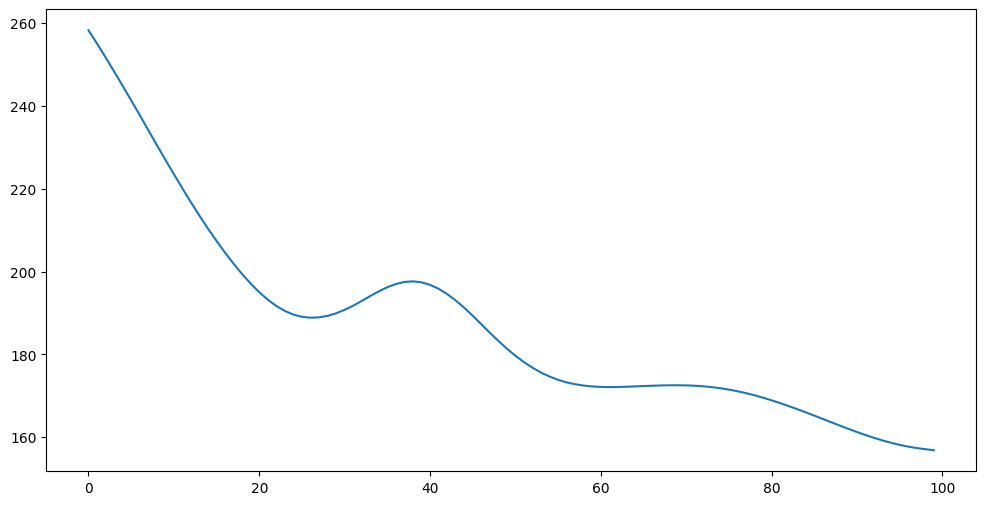

In [ ]:
use_cuda = 1 #gpu acceleration
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 100
learning_rate = 0.00001

model = model.to(device)   #moving model to gpu/cpu
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        #kl divergence loss between latent space and prior distribution
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        # reconstruction loss is the binary cross entropy loss
        # combine both for total loss
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [ ]:
#model is put in evaluation mode to switch off certain operation (like batch normalisation)
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device)) #convert array to pytorch sensor then to float
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [ ]:
print(model)

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=26, out_features=400, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=400, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (fc_mu): Linear(in_features=10, out_features=10, bias=True)
  (fc_var): Linear(in_features=10, out_features=10, bias=True)
  (decoder_input): Linear(in_features=10, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=400, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=400, out_features=400, bias=True)
      (1):

In [ ]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [ ]:
VAE_train_x.shape

torch.Size([725, 10])

In [ ]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [ ]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([722, 3, 36]) train_y: torch.Size([722, 1]) train_y_gan: torch.Size([722, 4, 1])
test_x: torch.Size([179, 3, 36]) test_y: torch.Size([179, 1]) test_y_gan: torch.Size([179, 4, 1])


## CGAN

In [ ]:
# y_label contains the sentimen score day wise
label = pd.read_csv("sentiment.csv")
y_label = label.iloc[:,1]

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, input_size)
        self.lstm_1 = nn.LSTM(input_size * 2, 50, batch_first=True, bidirectional=True)
        self.lstm_2 = nn.LSTM(100, 50, batch_first=True)
        self.linear_1 = nn.Linear(50, 32)
        self.linear_2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, y_label):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        embedded_label = self.embedding(y_label).unsqueeze(1)
        embedded_label = embedded_label.expand(-1, x.size(1), -1)
        x = torch.cat([x, embedded_label], dim=-1)
        h0_1 = torch.zeros(2, x.size(0), 50).to(device)  # Bidirectional LSTM requires 2 hidden states
        c0_1 = torch.zeros(2, x.size(0), 50).to(device)
        out_1, _ = self.lstm_1(x, (h0_1, c0_1))
        out_1 = self.dropout(out_1)
        h0_2 = torch.zeros(1, x.size(0), 50).to(device)
        c0_2 = torch.zeros(1, x.size(0), 50).to(device)
        out_2, _ = self.lstm_2(out_1, (h0_2, c0_2))
        out_2 = self.dropout(out_2)
        out_3 = self.linear_1(out_2[:, -1, :])
        out_4 = self.linear_2(out_3)
        return out_4

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, 32)
        self.gru1 = nn.GRU(64, 50, batch_first=True)
        self.gru2 = nn.GRU(50, 75, batch_first=True)
        self.gru3 = nn.GRU(75, 100, batch_first=True)
        self.linear1 = nn.Linear(100, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y_label):
        embedded_label = self.embedding(y_label).unsqueeze(1)
        embedded_label = embedded_label.expand(-1, x.size(1), -1)
        x = torch.cat([x, embedded_label], dim=-1)
        h0_1 = torch.zeros(1, x.size(0), 50).to(x.device)
        out_1, _ = self.gru1(x, h0_1)
        h0_2 = torch.zeros(1, x.size(0), 75).to(x.device)
        out_2, _ = self.gru2(out_1, h0_2)
        h0_3 = torch.zeros(1, x.size(0), 100).to(x.device)
        out_3, _ = self.gru3(out_2, h0_3)
        out_4 = self.relu(out_3[:, -1, :])
        out_5 = self.linear1(out_4)
        out_6 = self.relu(out_5)
        out_7 = self.linear2(out_6)
        out_8 = self.relu(out_7)
        out_9 = self.linear3(out_8)
        out_10 = self.sigmoid(out_9)
        return out_10


In [ ]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.0001
num_epochs = 100
#num_classes = 722

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(36).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x,yl)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y,yl)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data.detach(), yl)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data,yl)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item())
    histG[epoch] = sum(loss_G)
    histD[epoch] = sum(loss_D)
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

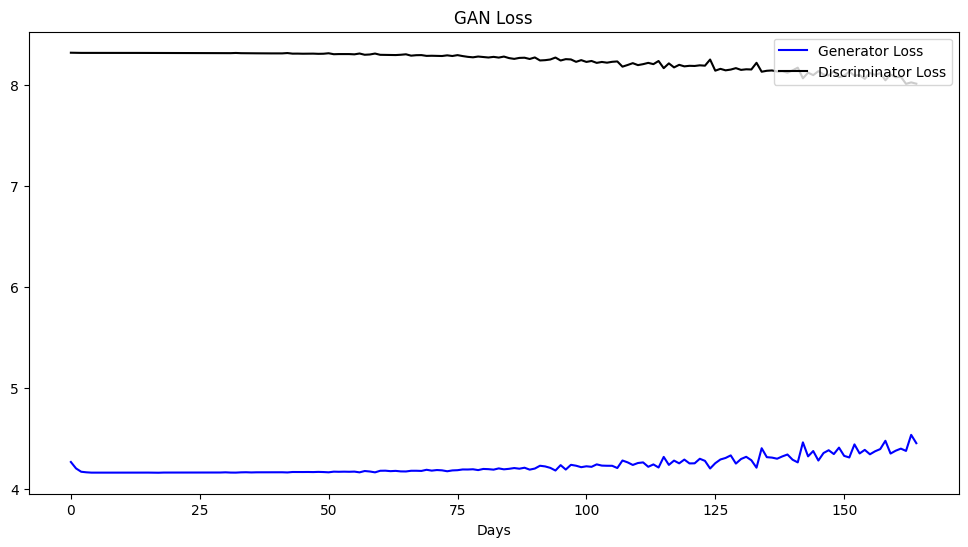

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [ ]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

In [ ]:
data.reset_index(drop=False, inplace=True)


([<matplotlib.axis.XTick at 0x7ad786d82c50>,
 [Text(18408.0, 0, 'May 2020'),
  Text(18414.0, 0, 'Jun 2020'),
  Text(18444.0, 0, 'Jul 2020'),
  Text(18477.0, 0, 'Aug 2020'),
  Text(18506.0, 0, 'Sep 2020'),
  Text(18536.0, 0, 'Oct 2020'),
  Text(18568.0, 0, 'Nov 2020'),
  Text(18597.0, 0, 'Dec 2020'),
  Text(18631.0, 0, 'Jan 2021'),
  Text(18659.0, 0, 'Feb 2021'),
  Text(18687.0, 0, 'Mar 2021'),
  Text(18718.0, 0, 'Apr 2021'),
  Text(18750.0, 0, 'May 2021'),
  Text(18779.0, 0, 'Jun 2021'),
  Text(18809.0, 0, 'Jul 2021'),
  Text(18841.0, 0, 'Aug 2021'),
  Text(18871.0, 0, 'Sep 2021'),
  Text(18901.0, 0, 'Oct 2021'),
  Text(18932.0, 0, 'Nov 2021'),
  Text(18962.0, 0, 'Dec 2021'),
  Text(18995.0, 0, 'Jan 2022'),
  Text(19024.0, 0, 'Feb 2022'),
  Text(19052.0, 0, 'Mar 2022'),
  Text(19083.0, 0, 'Apr 2022'),
  Text(19114.0, 0, 'May 2022'),
  Text(19144.0, 0, 'Jun 2022'),
  Text(19174.0, 0, 'Jul 2022'),
  Text(19205.0, 0, 'Aug 2022'),
  Text(19236.0, 0, 'Sep 2022'),
  Text(19268.0, 0, 'Oct 202

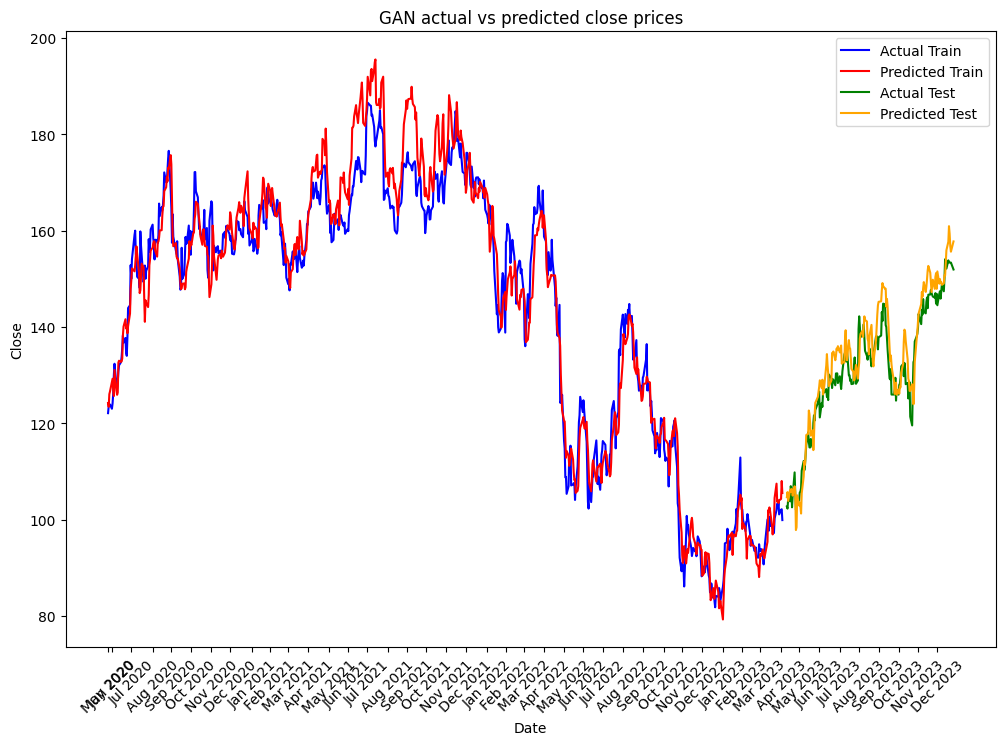

In [ ]:
plt.figure(figsize=(12, 8))
data['Date'] = pd.to_datetime(data['Date'])

# Extract month from the 'Date' column
data['Month'] = data['Date'].dt.month

# Find the indices where the month changes
month_changes = np.where(data['Month'].diff() != 0)[0]

plt.plot(data['Date'][:len(y_train_true)], y_train_true, label='Actual Train', color='blue')
plt.plot(data['Date'][:len(y_train_pred)], y_train_pred, label='Predicted Train', color='red')

plt.plot(data['Date'][split:(split + len(y_test_true))], y_test_true, label='Actual Test', color='green')
plt.plot(data['Date'][split:(split + len(y_test_pred))], y_test_pred, label='Predicted Test', color='orange')

plt.title('GAN actual vs predicted close prices')
plt.ylabel('Close')
plt.xlabel('Date')
plt.legend(loc = 'upper right')

plt.xticks(data['Date'][month_changes], data['Date'].dt.strftime('%b %Y')[month_changes], rotation=45)


## Performance Metric

In [ ]:
MSE1 = mean_squared_error(y_train_true, y_train_pred)
RMSE1 = math.sqrt(MSE1)
print(f'Training dataset MSE:{MSE1}')
print(f'Training dataset RMSE:{RMSE1}')
MSE2 = mean_squared_error(y_test_true, y_test_pred)
RMSE2 = math.sqrt(MSE2)
print(f'Testing dataset MSE:{MSE2}')
print(f'Testing dataset RMSE:{RMSE2}')

Training dataset MSE:24.010346823491563
Training dataset RMSE:4.901273459045624
Testing dataset MSE:20.074049838395463
Testing dataset RMSE:4.482326789546789
